In [1]:
import os 
import getopt
import sys

import numpy as np
import h5py
import pickle
import random
import copy
import pandas as pd
import math 

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Lambda, concatenate, Bidirectional, Dense, Dropout, Flatten, Conv1D,BatchNormalization,  MaxPooling1D, Bidirectional, GRU, TimeDistributed
from tensorflow.keras.initializers import Constant
import tensorflow as tf
from tensorflow import keras


/home/felix/anaconda3/envs/DeepFlyBrain_conda_env_gpu/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/felix/anaconda3/envs/DeepFlyBrain_conda_env_gpu/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/felix/anaconda3/envs/DeepFlyBrain_conda_env_gpu/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.i

In [2]:
# Prepare input data for deep explainer
df = pd.read_csv("/home/felix/cluster/fpacheco/Data/Robert_data/processed_data/LibA_wide_pivot_state3_with_id.csv")

# Function to one-hot encode a list of DNA sequences
def one_hot_encode_sequences(sequences, vocab):
    num_sequences = len(sequences)
    max_seq_length = max(len(seq) for seq in sequences)
    encoding = np.zeros((num_sequences, max_seq_length, len(vocab)), dtype=int)

    for i, sequence in enumerate(sequences):
        for j, base in enumerate(sequence):
            if base in vocab:
                index = vocab.index(base)
                encoding[i, j, index] = 1
            else:
                # Handle unexpected characters, e.g., if the sequence contains 'N' or others
                pass

    return encoding
vocab = ["A", "G", "C", "T"]
X = one_hot_encode_sequences(df.seq.values, vocab)
y = df.State_3E.values
ids = df.CRS.values

In [3]:
from tensorflow.keras.layers import Layer

class CustomNormalization(Layer):
    def __init__(self, **kwargs):
        super(CustomNormalization, self).__init__(**kwargs)
        
    def build(self, input_shape):
        # Add trainable variables for mean and standard deviation
        self.mean = self.add_weight("mean", shape=(1,), initializer="zeros", trainable=True)
        self.stddev = self.add_weight("stddev", shape=(1,), initializer="ones", trainable=True)
        super(CustomNormalization, self).build(input_shape)  # Be sure to call this at the end

    def call(self, inputs):
        # Normalize the inputs using the learned mean and standard deviation
        return (inputs - self.mean) / (self.stddev + 1e-8)


inputs = Input(shape=(X.shape[1],X.shape[2]), name="inputs")
layer = Conv1D(250, kernel_size=7, strides=1, activation='relu', name="conv1")(inputs)  # 250 7 relu
layer = Dropout(0.3)(layer)
layer = BatchNormalization()(layer)
layer = Conv1D(250, 8, strides=1, activation='softmax', name="conv2")(layer)  # 250 8 softmax
layer = BatchNormalization()(layer)
layer = MaxPooling1D(pool_size=2, strides=None, name="maxpool1")(layer)
layer = Dropout(0.3)(layer)
layer = Conv1D(250, 3, strides=1, activation='softmax', name="conv3")(layer)  # 250 3 softmax
layer = BatchNormalization()(layer)
layer = Dropout(0.3)(layer)
layer = Conv1D(100, 2, strides=1, activation='softmax', name="conv4")(layer)  # 100 3 softmax
layer = BatchNormalization()(layer)
layer = MaxPooling1D(pool_size=1, strides=None, name="maxpool2")(layer)
layer = Dropout(0.3)(layer)
layer = Flatten()(layer)
layer = Dense(300, activation='sigmoid')(layer)  # 300
layer = Dropout(0.3)(layer)
layer = Dense(200, activation='sigmoid')(layer)  # 300
predictions = Dense(1, activation='linear')(layer)
norm_predictions = CustomNormalization()(predictions)  # Assuming "predictions" is your existing output
model = Model(inputs=inputs, outputs=norm_predictions)

model.load_weights("/home/felix/cluster/fpacheco/Data/Robert_data/processed_data/10fold_cv/Model_CV1_LibA_wide_pivot_state3.h5")

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [5]:
import matplotlib 

def plot_a(ax, base, left_edge, height, color):
    a_polygon_coords = [
        np.array([
           [0.0, 0.0],
           [0.5, 1.0],
           [0.5, 0.8],
           [0.2, 0.0],
        ]),
        np.array([
           [1.0, 0.0],
           [0.5, 1.0],
           [0.5, 0.8],
           [0.8, 0.0],
        ]),
        np.array([
           [0.225, 0.45],
           [0.775, 0.45],
           [0.85, 0.3],
           [0.15, 0.3],
        ])
    ]
    for polygon_coords in a_polygon_coords:
        ax.add_patch(matplotlib.patches.Polygon((np.array([1,height])[None,:]*polygon_coords
                                                 + np.array([left_edge,base])[None,:]),
                                                facecolor=color, edgecolor=color))

def plot_c(ax, base, left_edge, height, color):
    ax.add_patch(matplotlib.patches.Ellipse(xy=[left_edge+0.65, base+0.5*height], width=1.3, height=height,
                                            facecolor=color, edgecolor=color))
    ax.add_patch(matplotlib.patches.Ellipse(xy=[left_edge+0.65, base+0.5*height], width=0.7*1.3, height=0.7*height,
                                            facecolor='white', edgecolor='white'))
    ax.add_patch(matplotlib.patches.Rectangle(xy=[left_edge+1, base], width=1.0, height=height,
                                            facecolor='white', edgecolor='white', fill=True))

def plot_g(ax, base, left_edge, height, color):
    ax.add_patch(matplotlib.patches.Ellipse(xy=[left_edge+0.65, base+0.5*height], width=1.3, height=height,
                                            facecolor=color, edgecolor=color))
    ax.add_patch(matplotlib.patches.Ellipse(xy=[left_edge+0.65, base+0.5*height], width=0.7*1.3, height=0.7*height,
                                            facecolor='white', edgecolor='white'))
    ax.add_patch(matplotlib.patches.Rectangle(xy=[left_edge+1, base], width=1.0, height=height,
                                            facecolor='white', edgecolor='white', fill=True))
    ax.add_patch(matplotlib.patches.Rectangle(xy=[left_edge+0.825, base+0.085*height], width=0.174, height=0.415*height,
                                            facecolor=color, edgecolor=color, fill=True))
    ax.add_patch(matplotlib.patches.Rectangle(xy=[left_edge+0.625, base+0.35*height], width=0.374, height=0.15*height,
                                            facecolor=color, edgecolor=color, fill=True))

def plot_t(ax, base, left_edge, height, color):
    ax.add_patch(matplotlib.patches.Rectangle(xy=[left_edge+0.4, base],
                  width=0.2, height=height, facecolor=color, edgecolor=color, fill=True))
    ax.add_patch(matplotlib.patches.Rectangle(xy=[left_edge, base+0.8*height],
                  width=1.0, height=0.2*height, facecolor=color, edgecolor=color, fill=True))

default_colors = {0:'green', 1:'blue', 2:'orange', 3:'red'}
default_plot_funcs = {0:plot_a, 1:plot_c, 2:plot_g, 3:plot_t}

default_colors = {0:'green', 1:'blue', 2:'orange', 3:'red'}
default_plot_funcs = {0:plot_a, 1:plot_c, 2:plot_g, 3:plot_t}

def plot_weights_given_ax(ax, array,
                 height_padding_factor,
                 length_padding,
                 subticks_frequency,
                 highlight,
                 colors=default_colors,
                 plot_funcs=default_plot_funcs):
    if len(array.shape)==3:
        array = np.squeeze(array)
    assert len(array.shape)==2, array.shape
    if (array.shape[0]==4 and array.shape[1] != 4):
        array = array.transpose(1,0)
    assert array.shape[1]==4
    max_pos_height = 0.0
    min_neg_height = 0.0
    heights_at_positions = []
    depths_at_positions = []
    for i in range(array.shape[0]):
        acgt_vals = sorted(enumerate(array[i,:]), key=lambda x: abs(x[1]))
        positive_height_so_far = 0.0
        negative_height_so_far = 0.0
        for letter in acgt_vals:
            plot_func = plot_funcs[letter[0]]
            color=colors[letter[0]]
            if (letter[1] > 0):
                height_so_far = positive_height_so_far
                positive_height_so_far += letter[1]                
            else:
                height_so_far = negative_height_so_far
                negative_height_so_far += letter[1]
            plot_func(ax=ax, base=height_so_far, left_edge=i, height=letter[1], color=color)
        max_pos_height = max(max_pos_height, positive_height_so_far)
        min_neg_height = min(min_neg_height, negative_height_so_far)
        heights_at_positions.append(positive_height_so_far)
        depths_at_positions.append(negative_height_so_far)
    for color in highlight:
        for start_pos, end_pos in highlight[color]:
            assert start_pos >= 0.0 and end_pos <= array.shape[0]
            min_depth = np.min(depths_at_positions[start_pos:end_pos])
            max_height = np.max(heights_at_positions[start_pos:end_pos])
            ax.add_patch(
                matplotlib.patches.Rectangle(xy=[start_pos,min_depth],
                    width=end_pos-start_pos,
                    height=max_height-min_depth,
                    edgecolor=color, fill=False))
            
    ax.set_xlim(-length_padding, array.shape[0]+length_padding)
    ax.xaxis.set_ticks(np.arange(0.0, array.shape[0]+1, subticks_frequency))
    height_padding = max(abs(min_neg_height)*(height_padding_factor),
                         abs(max_pos_height)*(height_padding_factor))
    ax.set_ylim(min_neg_height-height_padding, max_pos_height+height_padding)
    return ax

def plot_weights_modified(array, fig, n,n1,n2, title='', ylab='',
                              figsize=(20,2),
                 height_padding_factor=0.2,
                 length_padding=1.0,
                 subticks_frequency=20,
                 colors=default_colors,
                 plot_funcs=default_plot_funcs,
                 highlight={}):
    ax = fig.add_subplot(n,n1,n2) 
    ax.set_title(title)
    ax.set_ylabel(ylab)
    y = plot_weights_given_ax(ax=ax, array=array,
        height_padding_factor=height_padding_factor,
        length_padding=length_padding,
        subticks_frequency=subticks_frequency,
        colors=colors,
        plot_funcs=plot_funcs,
        highlight=highlight)
    return fig,ax


In [6]:
from deeplift.dinuc_shuffle import dinuc_shuffle, traverse_edges, shuffle_edges, prepare_edges
from collections import Counter

def onehot_dinuc_shuffle(s):
    s = np.squeeze(s)
    argmax_vals = "".join([str(x) for x in np.argmax(s, axis=-1)])
    shuffled_argmax_vals = [int(x) for x in traverse_edges(argmax_vals,
                            shuffle_edges(prepare_edges(argmax_vals)))]
    to_return = np.zeros_like(s)
    to_return[list(range(len(s))), shuffled_argmax_vals] = 1
    return to_return

shuffle_several_times = lambda s: np.array([onehot_dinuc_shuffle(s) for i in range(100)])

In [11]:
import shap

rn=np.random.choice([X,  X[:,::-1,::-1]][0].shape[0], 1000, replace=False)
explainer = shap.DeepExplainer((model.inputs, model.layers[-1].output), X[rn])

if os.path.exists("/home/felix/cluster/fpacheco/Data/Robert_data/processed_data/10fold_cv/deep_explainer/") is False:
    os.mkdir("/home/felix/cluster/fpacheco/Data/Robert_data/processed_data/10fold_cv/deep_explainer/")

FileNotFoundError: [Errno 2] No such file or directory: '/home/felix/cluster/fpacheco/Data/Robert_data/processed_data/10fold_cv/deep_explainer/LibA.Seq8072_deep_explainer.png'

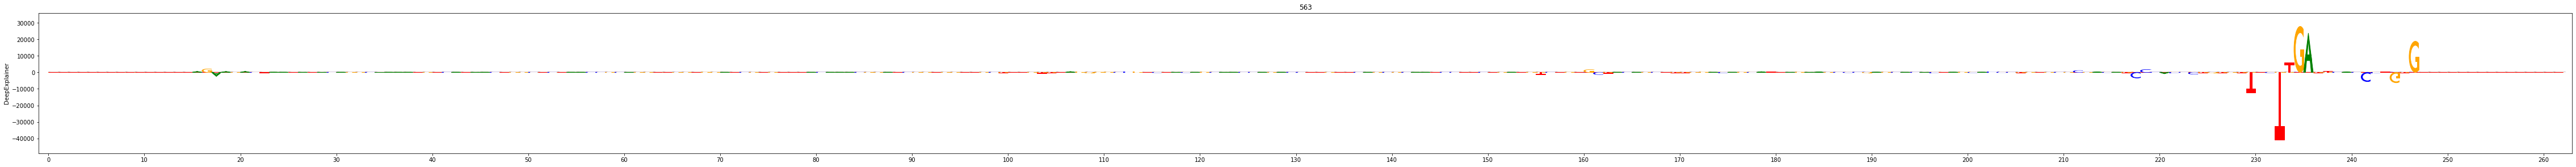

In [12]:
import matplotlib.pyplot as plt

shap_values, indexes = explainer.shap_values(X, ranked_outputs=1)

for i in range(0, X.shape[0]):
    ntrack=2
    fig = plt.figure(figsize=(80,10))
    _, ax1 =plot_weights_modified(shap_values[0][0]*X[i],fig,ntrack,1,1,title=i, subticks_frequency=10,ylab="DeepExplainer")

    plt.savefig("/home/felix/cluster/fpacheco/Data/Robert_data/processed_data/10fold_cv/deep_explainer/"+ids[i] +'_deep_explainer.png')
    plt.close('all')


In [10]:
X.shape


(8478, 262, 4)